In [54]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [55]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [56]:
OB = 'OB4'

In [104]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[3]).T
#x= np.array([wl, flux, error,error]).T
#exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
#exc_reg_2 = (~((x[:,0] > 13400) & (x[:,0] < 14400))) & (~((x[:,0] > 18000) & (x[:,0] < 19500))) & \
#          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
#          (~((x[:,0] > 7520) & (x[:,0] < 7570))) & \
#          (x[:,0] > 4000) & (x[:,0] < 22500) & (~((x[:,0] > 12600) & (x[:,0] < 12800))) 

#          (~((x[:,0] > 6000) & (x[:,0] < 7200)))  & \

#exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
#          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
#          (x[:,0] > 4000) & (x[:,0] < 22500)
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 5555) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

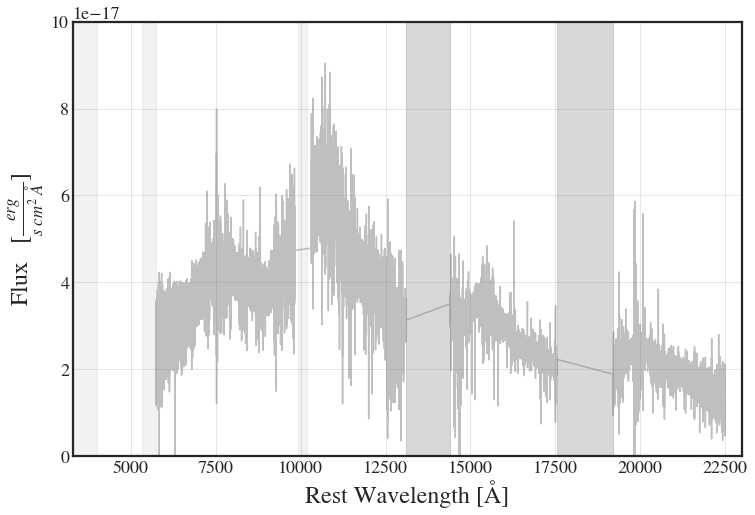

In [105]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2], 
#                 color='grey', alpha=0.9)
plt.ylim(0, 1e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [60]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [61]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

#### Fit structure

In [90]:
#p = lmfit.Parameters()
#OB = 'OB4'
#with open("./data/%s_n_init.json"%OB, 'r') as infile:
#    p.load(infile)
pickle_in = open("./Data/OB4/OB4_3_peaks_with_gaussian.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
print(lum_dist_arr(p['N'],p['vphot'],n_days=4.40), p['ve'], p['vphot'])


start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 
p

46.27190407809023 <Parameter 've', value=7.962696640917995 +/- 1.78, bounds=[0:10]> <Parameter 'vphot', value=0.17252131613287214 +/- 0.000523, bounds=[0:1]>
Time elapsed: 0.9020493507385254


name,value,standard error,relative error,initial value,min,max,vary
T,3229.35669,1.86202876,(0.06%),3217.819292907171,2500.00000,7500.00000,True
N,3.1295e-29,1.0755e-31,(0.34%),3.2010461509524127e-29,-inf,inf,True
vphot,0.17252132,5.2321e-04,(0.30%),0.17304530867385287,0.00000000,1.00000000,True
vmax,0.22791806,4.0757e-04,(0.18%),0.2275609224257,0.00000000,1.00000000,True
t0,385200.000,,(0.18%),385200,-inf,inf,False
tau,0.36046558,0.00550567,(1.53%),0.38361520428160834,0.00000000,10.0000000,True
vref,0.00000000,,(1.53%),0.0,0.00000000,1.00000000,False
ve,7.96269664,1.77601098,(22.30%),7.104226961196531,0.00000000,10.0000000,True
occult,8.15231253,0.10853579,(1.33%),7.656267982349197,0.10000000,20.0000000,True
amp1,0.96206669,0.00545736,(0.57%),0.9278409771344276,0.01000000,5.00000000,True


In [91]:
lum_dist_arr(mi2.params['N'],mi2.params['vphot'],n_days=4.40), mi2.params['ve'], mi2.params['vphot']

(42.67574568892263,
 <Parameter 've', value=7.956674018918994, bounds=[0:10]>,
 <Parameter 'vphot', value=0.1612724495966959, bounds=[0:1]>)

In [96]:
print(lum_dist_arr(p['N'],p['vphot'],n_days=4.40), p['ve'], p['vphot'])
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g = Gaussian1DKernel(stddev=5)

42.67574568892263 <Parameter 've', value=7.956674018918994, bounds=[0:10]> <Parameter 'vphot', value=0.1612724495966959, bounds=[0:1]>


(Text(0, 0.5, '$F_\\lambda  [10^{-17} \\frac{erg}{s \\ cm^2 \\ Å} ] $'),)

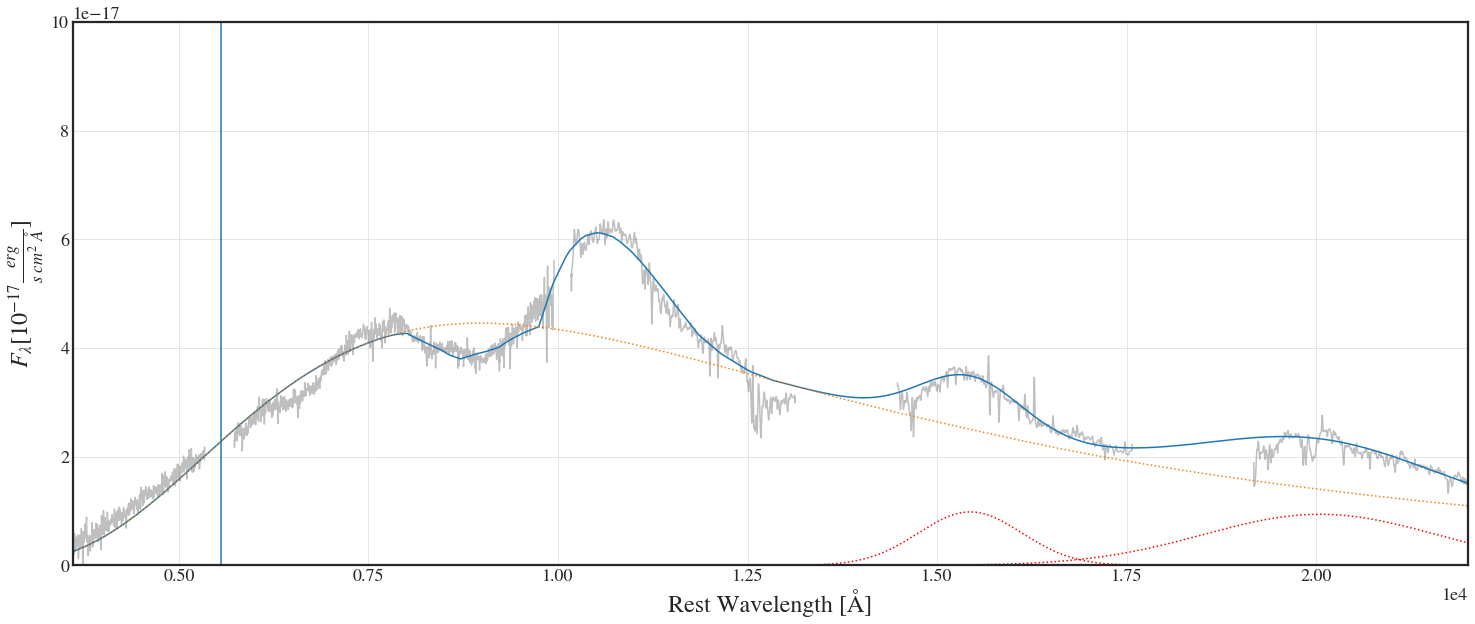

In [97]:
p = lmfit.Parameters()
with open("./Data/%s_3gaussian.json"%OB, 'r') as infile:
    p.load(infile)

#p
lum_dist_arr(p['N'],p['vphot'],n_days=3.45), p['ve'], p['vphot']


path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)


i = 3
plt.figure(figsize=(25,10))

for i in [3]: 
    g = Gaussian1DKernel(stddev=10)

    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan

    
    amp1 = np.copy(gaussian(wl2, 1e-17*p['amp1'].value, p['cen1'].value*1e10, p['sig1'].value*1e10))
    amp2 = gaussian(wl2, 1e-17*p['amp2'].value, p['cen2'].value*1e10, p['sig2'].value*1e10)
    
    flux_fit = residual(p, wl2*1e-10)
    p['tau'].value=0
    flux_fit2 = residual(p, wl2*1e-10)
    p['amp1'].value=0
    p['amp2'].value=0
    flux_fit3 = residual(p, wl2*1e-10)

    
#plt.ylim(-0.8, 0.8)
    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan), color='grey', alpha=0.5)
    plt.plot(wl2, flux_fit)
    #plt.plot(wl2, flux_fit2)
    plt.plot(wl2, flux_fit3, ls='dotted')
    plt.plot(wl2, amp1, ls='dotted', color='red')
    plt.plot(wl2, amp2, ls='dotted', color='red')
    

plt.xlim(3600, 22000)
plt.ylim(0, 1e-16) 
plt.axvline(5555)
plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda  [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $'), 
#plt.axvline(15500)
#plt.axvline(15250, ls='--')
#plt.savefig('Pictures/third_line.png', dpi=300)

In [92]:
with open("./data/%s_3gaussian.json"%OB, 'w') as outfile:
    mi2.params.dump(outfile)

In [165]:
p = lmfit.Parameters()
with open("./Data/%s_3gaussian.json"%OB, 'r') as infile:
    p.load(infile)

#p
lum_dist_arr(p['N'],p['vphot'],n_days=4.45), p['ve'], p['vphot']
p['sig1'].vary = True
p['sig2'].vary = True
#p['sig3'].vary = True

In [ ]:
#next step decrease width, vary width, remove telluric region 3
#decrease range

In [179]:
pickle_in = open("./Data/OB4/OB4_3_peaks_XL_2.pkl","rb")
emcee_res = pickle.load(pickle_in)
p2 = emcee_res.params
print(lum_dist_arr(p2['N'],p2['vphot'],n_days=4.43), p2['ve'], p2['vphot'])
#p['ve'].max = 10
p2['ve'].max = 10
#p2['N'].value = 3.65e-29
p2['sig1'].value = 0.55e-7
p2['sig2'].value = 1.10e-7
#p2['sig1'].vary = True
#p2['sig2'].vary = True

#p2['amp1'].value = 
#p2['amp2'].value = 
p2

43.826857577502054 <Parameter 've', value=1.403252410975893 +/- 0.636, bounds=[0:10]> <Parameter 'vphot', value=0.1743698679909492 +/- 0.000835, bounds=[0:1]>


name,value,standard error,relative error,initial value,min,max,vary
T,3227.88062,1.18530306,(0.04%),3227.846574474768,2500.00000,7500.00000,True
N,3.1283e-29,6.2878e-32,(0.20%),3.128645232845264e-29,-inf,inf,True
vphot,0.17436987,8.3539e-04,(0.48%),0.1744120616162733,0.00000000,1.00000000,True
vmax,0.22793498,3.3890e-04,(0.15%),0.22800049335034417,0.00000000,1.00000000,True
t0,385200.000,,(0.15%),385200,-inf,inf,False
tau,0.43241095,0.02549492,(5.90%),0.46366123501263673,0.00000000,10.0000000,True
vref,0.00000000,,(5.90%),0.0,0.00000000,1.00000000,False
ve,1.40325241,0.63556190,(45.29%),0.9583911740168418,0.00000000,10.0000000,True
occult,7.66619648,0.08597905,(1.12%),7.66480143277882,0.10000000,20.0000000,True
amp1,0.88083759,0.00492446,(0.56%),0.8807279982794638,0.01000000,5.00000000,True


In [19]:
pickle_in = open("./Data/OB4/OB4_3_peaks_filtered.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
print(lum_dist_arr(p['N'],p['vphot'],n_days=4.4), p['ve'], p['vphot'])

#p['ve'].max = 100
#p['occult'].max = 1
#p['occult'].value = 1
#p['occult'].vary = False

p['sig1'].vary = False; p['sig2'].vary = False
p['amp1'].min = -0.1; p['amp2'].min = -0.1; p['amp1'].value = 0.001; p['amp2'].value = 0.001; 
p['amp1'].vary=False; p['amp2'].vary=False; 
p

45.924752020212885 <Parameter 've', value=7.104226961196531 +/- 3.54, bounds=[0:10]> <Parameter 'vphot', value=0.17304530867385287 +/- 0.000721, bounds=[0:1]>


name,value,standard error,relative error,initial value,min,max,vary
T,3217.81929,1.72184625,(0.05%),3227.846574474768,2500.00000,7500.00000,True
N,3.2010e-29,1.0093e-31,(0.32%),3.128645232845264e-29,-inf,inf,True
vphot,0.17304531,7.2132e-04,(0.42%),0.1744120616162733,0.00000000,1.00000000,True
vmax,0.22756092,4.1314e-04,(0.18%),0.22800049335034417,0.00000000,1.00000000,True
t0,385200.000,,(0.18%),385200,-inf,inf,False
tau,0.38361520,0.01695189,(4.42%),0.46366123501263673,0.00000000,10.0000000,True
vref,0.00000000,,(4.42%),0.0,0.00000000,1.00000000,False
ve,7.10422696,3.54458664,(49.89%),0.9583911740168418,0.00000000,10.0000000,True
occult,7.65626798,0.09222926,(1.20%),7.66480143277882,0.10000000,20.0000000,True
amp1,1.0000e-03,0.00527656,(527.66%),0.8807279982794638,-0.10000000,5.00000000,False


In [27]:
pickle_in = open("./data/OB4/OB4_3_peaks_filtered.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
print(lum_dist_arr(p['N'],p['vphot'],n_days=3.41))

#p['ve'].max = True
#p['sig1'].vary=False; p['sig2'].vary=False; 
#p['amp1'].min = 0; p['amp2'].min = 0; 
#p['amp1'].vary=False; p['amp2'].vary=False; 
#p['amp1'].value = 0; p['amp2'].value = 0; 
p['cen1'].vary=True; p['cen2'].vary=True; 
p['cen2'].value = 2.03e-6
p

35.59168281566498


name,value,standard error,relative error,initial value,min,max,vary
T,3217.81929,1.72184625,(0.05%),3227.846574474768,2500.00000,7500.00000,True
N,3.2010e-29,1.0093e-31,(0.32%),3.128645232845264e-29,-inf,inf,True
vphot,0.17304531,7.2132e-04,(0.42%),0.1744120616162733,0.00000000,1.00000000,True
vmax,0.22756092,4.1314e-04,(0.18%),0.22800049335034417,0.00000000,1.00000000,True
t0,385200.000,,(0.18%),385200,-inf,inf,False
tau,0.38361520,0.01695189,(4.42%),0.46366123501263673,0.00000000,10.0000000,True
vref,0.00000000,,(4.42%),0.0,0.00000000,1.00000000,False
ve,7.10422696,3.54458664,(49.89%),0.9583911740168418,0.00000000,10.0000000,True
occult,7.65626798,0.09222926,(1.20%),7.66480143277882,0.10000000,20.0000000,True
amp1,0.92784098,0.00527656,(0.57%),0.8807279982794638,0.01000000,5.00000000,True


In [107]:
pickle_in = open("./Data/OB4/OB4_3_peaks_with_gaussian.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
print(lum_dist_arr(p['N'],p['vphot'],n_days=4.4), p['ve'], p['vphot'])

#p['sig1'].value = 0.55e-7; p['sig2'].value = 1.10e-7; 
#p['sig1'].vary=False; p['sig2'].vary=False; 
#p['amp1'].min = 0; p['amp2'].min = 0; 
#p['amp1'].vary=False; p['amp2'].vary=False; 
#p['sig1'].vary=False; p['sig2'].vary=False; 
#p['cen1'].vary=False; p['cen2'].vary=False; 
#p['amp1'].value = 0.0; p['amp2'].value = 0.0;
#p['cen2'].value=2.03e-6; p['sig2'].value=7.2e-8; 

p

46.27190407809023 <Parameter 've', value=7.962696640917995 +/- 1.78, bounds=[0:10]> <Parameter 'vphot', value=0.17252131613287214 +/- 0.000523, bounds=[0:1]>


name,value,standard error,relative error,initial value,min,max,vary
T,3229.35669,1.86202876,(0.06%),3217.819292907171,2500.00000,7500.00000,True
N,3.1295e-29,1.0755e-31,(0.34%),3.2010461509524127e-29,-inf,inf,True
vphot,0.17252132,5.2321e-04,(0.30%),0.17304530867385287,0.00000000,1.00000000,True
vmax,0.22791806,4.0757e-04,(0.18%),0.2275609224257,0.00000000,1.00000000,True
t0,385200.000,,(0.18%),385200,-inf,inf,False
tau,0.36046558,0.00550567,(1.53%),0.38361520428160834,0.00000000,10.0000000,True
vref,0.00000000,,(1.53%),0.0,0.00000000,1.00000000,False
ve,7.96269664,1.77601098,(22.30%),7.104226961196531,0.00000000,10.0000000,True
occult,8.15231253,0.10853579,(1.33%),7.656267982349197,0.10000000,20.0000000,True
amp1,0.96206669,0.00545736,(0.57%),0.9278409771344276,0.01000000,5.00000000,True


#### Markov Chain Monto Carlo to sample distribution

In [108]:
mini = lmfit.Minimizer(lnprob, p)

start = time.time()
nwalkers = 30 #v = p.valuesdict()
res2 = mini.emcee(nwalkers=nwalkers, burn=0, steps=1000, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 ) 
#with open("./Data/OB4/OB4_3_peaks_XL_2.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 1000/1000 [25:04<00:00,  1.50s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 13 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [144.11832531 145.33811718  83.60047543 132.30406384 105.70960338
  93.1441828  135.375169   146.00081266 144.51694607 124.52506058
 110.93307543 137.37379964 144.67900308]
Time elapsed [hours]: 0.4183479364713033


In [111]:
dl

Series([], dtype: float64)

(44.86808288913031, 44.612908330969354, 45.137724617234326)

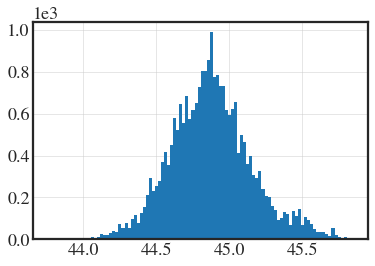

In [113]:
#lambda>5.000

flat = res2.flatchain
steady = 200*nwalkers
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=4.40 ) #* np.sqrt(np.pi)
plt.hist(dl, bins=100); 
np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9)

(26.070727394553273, 25.72364999456415, 26.398330589768882)

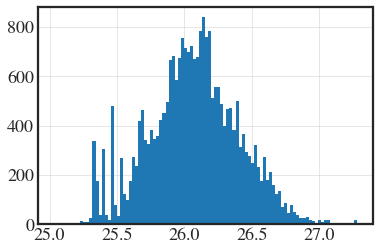

In [71]:
#lambda<10.000

flat = res2.flatchain
steady = 1000*nwalkers
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=4.40 ) #* np.sqrt(np.pi)
plt.hist(dl, bins=100); 
np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9)

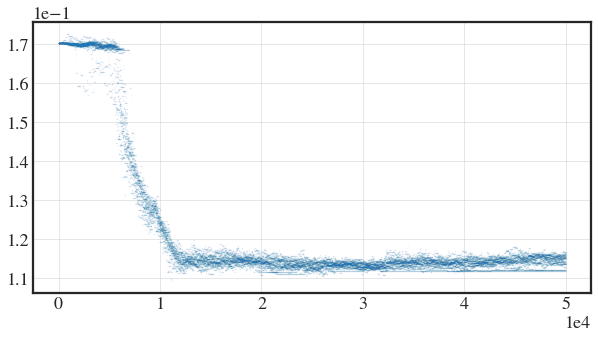

In [72]:
flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=0.1 ) 


(48.740962116299734, 48.587527486362085, 48.901157993862505)

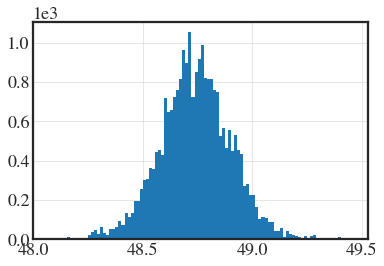

In [66]:
#lambda<12000

flat = res2.flatchain
steady = 1000*nwalkers
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=4.40 ) #* np.sqrt(np.pi)
plt.hist(dl, bins=100); 
np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9)

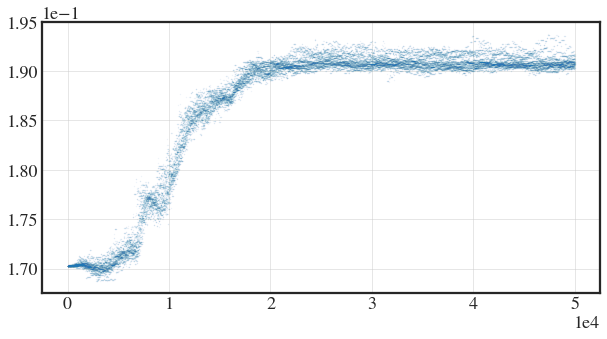

In [65]:
flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=0.1 ) 


In [53]:
with open("./Data/OB4/OB4_3_peaks_lambda_13000_1.pkl", 'wb') as outfile:
    pickle.dump(res2, outfile) 



In [47]:
res2.acceptance_fraction

array([0.3531, 0.1585, 0.3512, 0.3607, 0.34  , 0.3528, 0.3265, 0.3418,
       0.3672, 0.3522, 0.3386, 0.2821, 0.3596, 0.3474, 0.3418, 0.3434,
       0.3317, 0.2983, 0.3497, 0.3468])

In [31]:
#with open("./Data/OB4/OB4_3_peaks_with_gaussian.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

In [23]:
#with open("./Data/OB4/OB4_3_peaks_filtered_3600.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

(46.267470742670106, 46.079501228762645, 46.44898471639218)

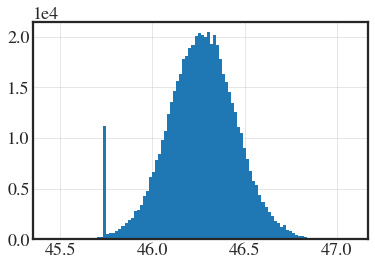

In [30]:
flat = res2.flatchain
#dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=4.40 ) #* np.sqrt(np.pi)
#plt.hist(dl, bins=100); 
#print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

flat = res2.flatchain
steady = 1000*nwalkers
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=4.40 ) #* np.sqrt(np.pi)
plt.hist(dl, bins=100); 
np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9)

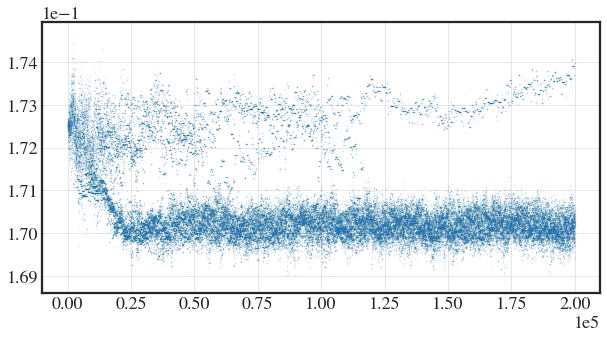

In [44]:
flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=0.1 ) 


45.95027674125105 45.743145430074286 46.196411241509736


(45.93462327655162, 45.72278885276668, 46.17441696033752)

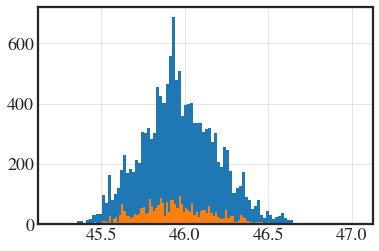

In [16]:
#with open("./Data/OB4/OB4_3_peaks.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile)

In [114]:
with open("./Data/OB4/OB4_No_UV.pkl", 'wb') as outfile:
    pickle.dump(res2, outfile) 

(44.0290361133067, 43.783677794652675, 44.30843540232117)

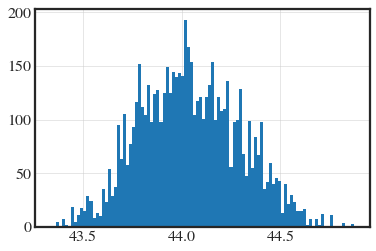

In [22]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'][10000:], flat['vphot'][10000:], n_days=4.45 ) #* np.sqrt(np.pi)
plt.hist(dl, bins=100); 
np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9)

In [19]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,3217.81929,1.72184625,(0.05%),3227.846574474768,2500.00000,7500.00000,True
N,3.2010e-29,1.0093e-31,(0.32%),3.128645232845264e-29,-inf,inf,True
vphot,0.17304531,7.2132e-04,(0.42%),0.1744120616162733,0.00000000,1.00000000,True
vmax,0.22756092,4.1314e-04,(0.18%),0.22800049335034417,0.00000000,1.00000000,True
t0,385200.000,,(0.18%),385200,-inf,inf,False
tau,0.38361520,0.01695189,(4.42%),0.46366123501263673,0.00000000,10.0000000,True
vref,0.00000000,,(4.42%),0.0,0.00000000,1.00000000,False
ve,7.10422696,3.54458664,(49.89%),0.9583911740168418,0.00000000,10.0000000,True
occult,7.65626798,0.09222926,(1.20%),7.66480143277882,0.10000000,20.0000000,True
amp1,0.92784098,0.00527656,(0.57%),0.8807279982794638,0.01000000,5.00000000,True


In [17]:
import corner

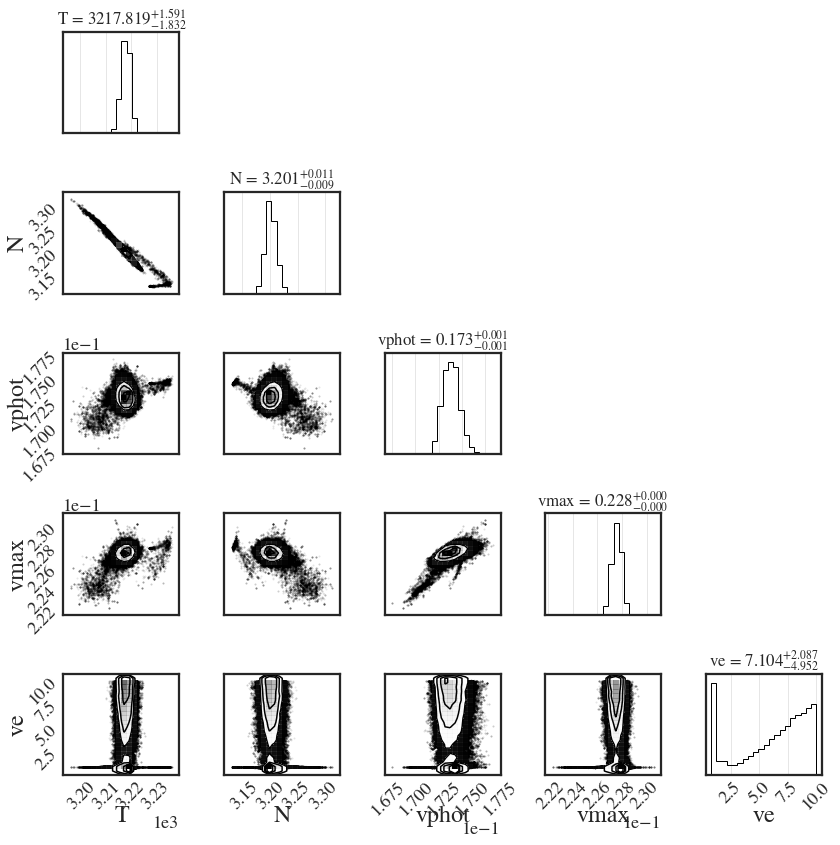

In [18]:
fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['ve']]).T, 
                           labels=['T', 'N', 'vphot','vmax', 've'], show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

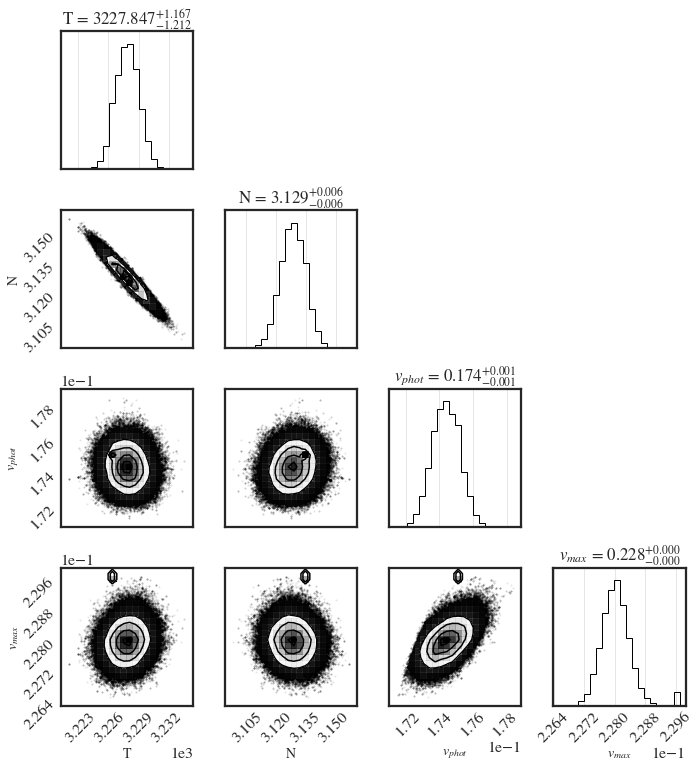

In [21]:
n_box = 4
fig,ax = plt.subplots(figsize=(10,11),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB4_covariance_small.png', dpi=300)

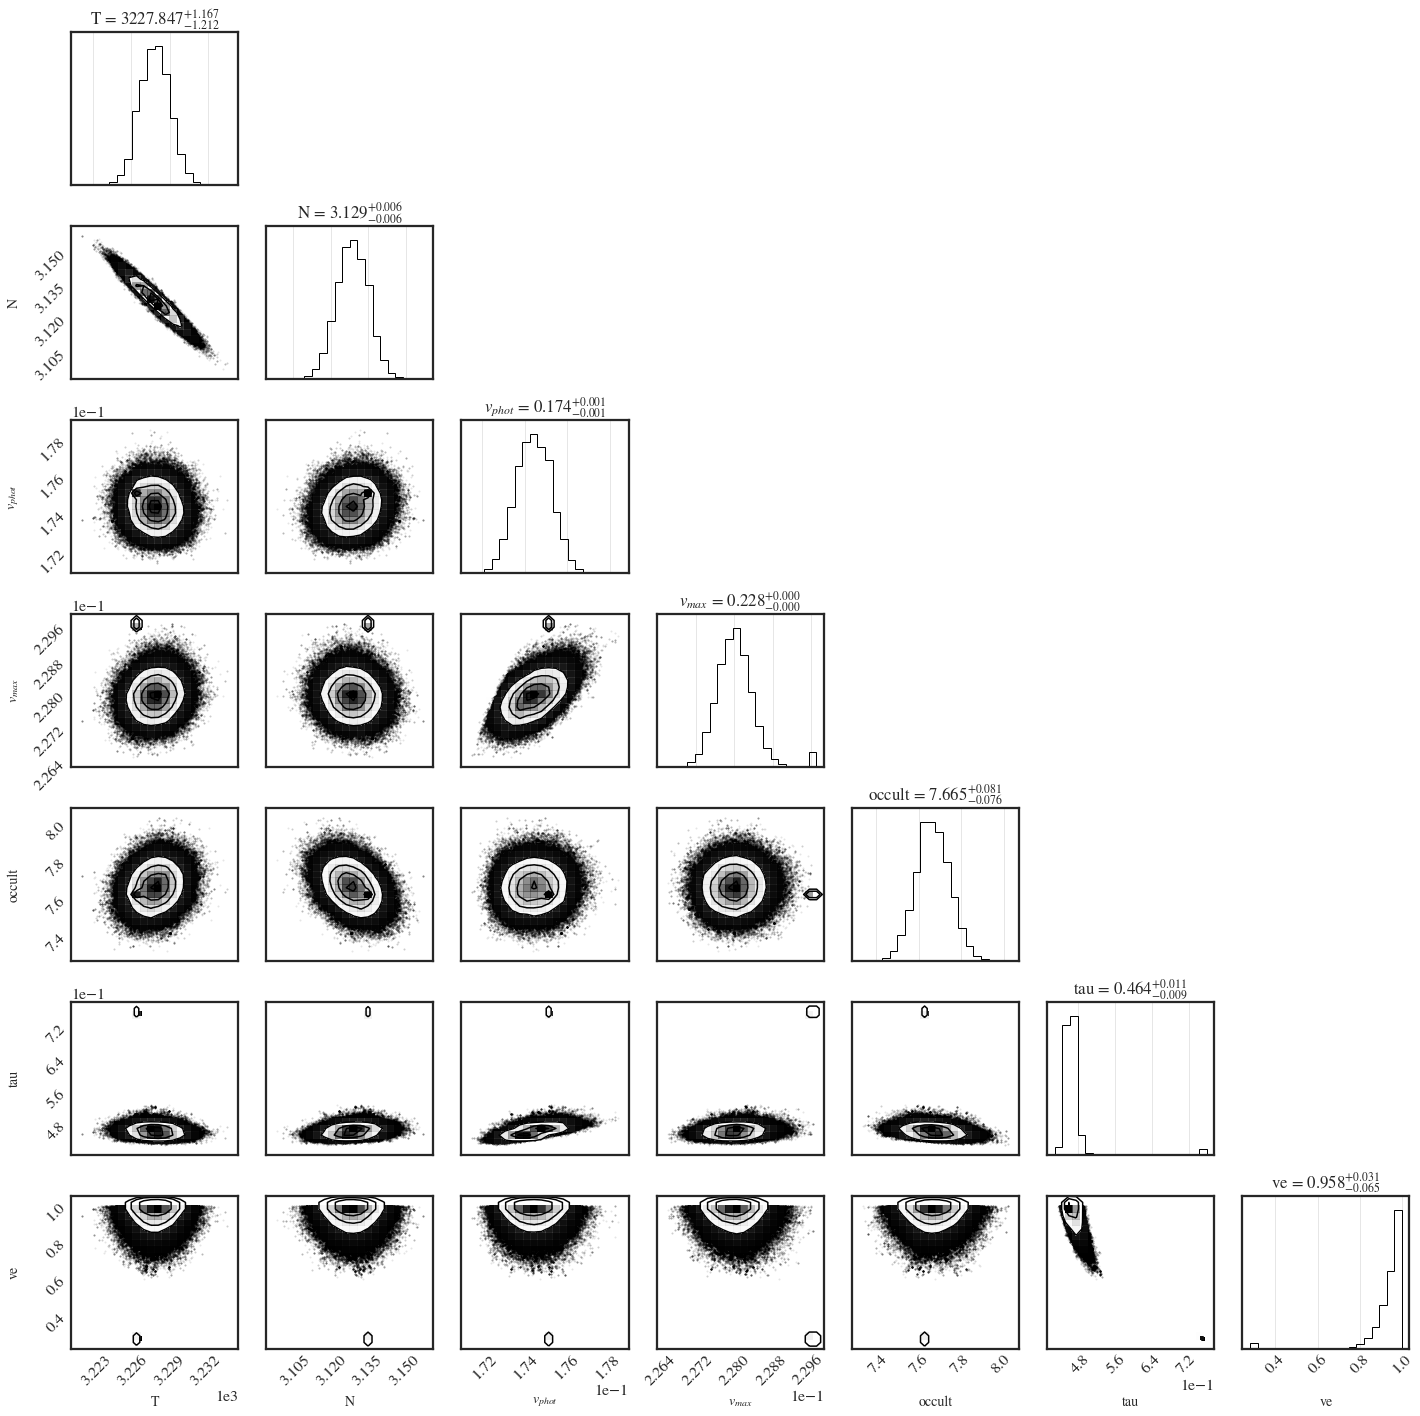

In [22]:
n_box = 7
fig,ax = plt.subplots(figsize=(20,20),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve']]).T, 
              labels=['T', 'N', r'$v_{phot}$',r'$v_{max}$','occult','tau','ve'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout()

#plt.savefig('Pictures/OB4_covariance_large.png', dpi=300)

In [ ]:
#with open("./Data/OB4/OB4_3.pkl", 'wb') as outfile:
#    pickle.dump(res, outfile)